Pending Update:
- [ ] check whether the y is mmol, if it is, times 22.4 to convert the value to cm^3
- [x] need to have the forward dots to be filled while the backward dots to be empty
- [ ] able to convert from gravimetric to volumetric 
- [x] customize output names to fileame + '.png'
- [x] able to include BET SA on the isotherm plot
- [x] feed in all the files in the same folder

In [261]:
def getfilename():
    path = os.getcwd()    
    filewithext = []
    filename = []
    for file in [doc for doc in os.listdir(path) if doc.endswith('.XLS')]:  
        filewithext.append(file)
        filename.append(file.replace(".XLS",""))
    return(filewithext, filename)


#[sorption_data_to_pngs(filename) for filename in getfilename()[0]]

def div_ads_des(pddataframe):
    max_x = pddataframe.max()[0]
    ads_x, ads_y, des_x, des_y = [],[],[],[]
    findmax = False
    for i in range(len(pddataframe)): 
        if findmax == False:
                if clean_iso.loc[i,'x'] != max_x:
                    ads_x.append(clean_iso.loc[i, "x"])
                    ads_y.append(clean_iso.loc[i, "y"])
                elif clean_iso.loc[i,'x'] == max_x:
                    findmax = True
        else:
            des_x.append(clean_iso.loc[i, "x"])
            des_y.append(clean_iso.loc[i, "y"])
    return (ads_x, ads_y, des_x, des_y)
    
def data_cleaning(filename):
    df = pd.read_excel(filename)

    #Rename all the columns in to numbers
    rename_col = []
    for index, value in enumerate(df.columns):
        rename_col.append(str(index))
    df.columns = rename_col

    Global_pivot  = df[df.eq('Summary Report').any(1)]
    Global_pivot.index
    df.loc[Global_pivot.index,:]

    #find the corresponding column "indices" and now you can extract the columns by 'SA_pivot.index', 'ISO_pivot.index', and 'PV_pivot.index'
    T_df = df.loc[Global_pivot.index,:].T
    SA_pivot = T_df[T_df.eq('Summary Report').any(1)]
    ISO_pivot = T_df[T_df.eq('Isotherm Tabular Report').any(1)]
    PV_pivot = T_df[T_df.eq('dV/dlog(W) Pore Volume vs. Pore Width').any(1)]

    #sa, iso and pv columns I want
    sa_name = re.sub('\D','',str(SA_pivot.index))
    sa_value = str(int(sa_name) + 1)
    iso_x = re.sub('\D','',str(ISO_pivot.index))
    iso_y = str(int(iso_x) + 2)
    pv_x = re.sub('\D','',str(PV_pivot.index))
    pv_y = str(int(pv_x) + 1)

    #Up to this point, I can call out the correspondig columns by raw_sa = df[[sa_name, sa_value]] and change the sa_name 
    #into iso_x, etc

    #sanity check
    # print('sa columns of interest are', sa_name, 'and', sa_value)
    # print('iso columns of interest are', iso_x, 'and', iso_y)
    # print('pv columns of interest are', pv_x, 'and', pv_y)

    #extract surface area, isotherm, and pore volumn; may need to check the indexes if different reports were generated
    raw_sa = df[[sa_name,sa_value]]

    raw_pv = df[[pv_x,pv_y]]

    #display surface area
    raw_sa
    sa_row  = raw_sa[raw_sa.eq('BET Surface Area:').any(1)]
    BET_SA = str(sa_row.loc[32][0]+' '+ sa_row.loc[32][1])

    #Isotherm Plot
    #extract the x (p/p0) and y (Quantity Adsorbed (cm^3/g)) values for isotherm
    raw_iso = df[[iso_x,iso_y]] 

    #clean the raw data with only data left, i.e. dropped the empty entry
    raw_iso = raw_iso.dropna()
    #Find the index of Pore Width  and dV/dlog row

    raw_iso = raw_iso.reset_index()
    index = raw_iso.index
    condition = raw_iso[iso_x] == "Relative Pressure (p/p°)"
    x_indices = index[condition]
    #get only rows with "Relative Pressure (p/p°)"
    x_indices_list = x_indices.tolist()
    raw_iso = raw_iso.loc[int(x_indices_list[0])+1:,:]

    #clean raw so it only left with the header and x, y
    raw_iso = raw_iso.reset_index()
    clean_iso = raw_iso[[iso_x, iso_y]]
    clean_iso = clean_iso.rename(columns={iso_x: "x", iso_y: "y"})

    #Pore Volumn
    #extract the x (Pore Width) and y (dV/dlog (cm^3/g)) values for pore volumn
    raw_pv = df[[pv_x, pv_y]]
    #clean the raw data with only data left, i.e. dropped the empty entry
    raw_pv = raw_pv.dropna()
    #Find the index of Pore Width  and dV/dlog row
    raw_pv = raw_pv.reset_index()
    index = raw_pv.index
    condition = raw_pv[pv_x] == "Pore Width (Å)"
    x_indices = index[condition]
    #get only rows with "Pore Width (Å)"
    x_indices_list = x_indices.tolist()
    raw_pv = raw_pv.loc[int(x_indices_list[0])+1:,:]
    #clean raw so it only left with the header and x, y
    raw_pv = raw_pv.reset_index()
    clean_pv = raw_pv[[pv_x, pv_y]]
    clean_pv = clean_pv.rename(columns={pv_x: "x", pv_y: "y"})
    return BET_SA, clean_iso, clean_pv
def plot_pv(clean_pv,colors,i):
    clean_pv.plot(x='x',y='y',
              kind = 'line',
              title='Pore Volume',
              xlabel = 'Pore Width (Å)',
              ylabel = 'dV/dlog(W) Pore Volume (cm³/g)',
              xlim = (5,40),
              ylim = (clean_pv.min().y, clean_pv.max().y * 1.1),
              label = filename[i].replace('.XLS',''),
              color=colors[i]
              )
    plt.savefig(filename[i].replace('.XLS','') + 'pv.png')

def plot_ads_des(clean_iso,colors,i):
    plt.scatter(div_ads_des(clean_iso)[0], 
                div_ads_des(clean_iso)[1], 
                s=40, 
                facecolors=colors[i], 
                edgecolors=colors[i]
               )

    plt.legend(labels = [filename[i].replace(extension,'')],loc=4,frameon=False)
    plt.scatter(div_ads_des(clean_iso)[2], 
                div_ads_des(clean_iso)[3], 
                s=40, 
                facecolors='none', 
                edgecolors=colors[i])
    plt.title(data_type)
    #filename[i].replace(extension,'')

In [258]:
import matplotlib.pyplot as plt
import csv
import re
import pandas as pd
import numpy as np
import os

colors = ['red','green','orange','purple','blue','yellow','grey']
data_type = 'N$\mathregular{_{2}}$ Isotherm'
extension = '.XLS'
filename = getfilename()[0]

In [259]:
#extracted data frame info into the main coding area 
#[this one plots and saves individual png]
figure_num = []
ind = 0
for i in filename:
    BET_SA = data_cleaning(i)[0]
    clean_iso = data_cleaning(i)[1]
    plot_ads_des(clean_iso,colors,ind)
    ind += 1
    plt.text(0.1, clean_iso.min().y * 1.05, BET_SA)
    plt.savefig(i.replace(extension,'') + 'iso.png')
    plt.close()
ind = 0
for i in filename:
    clean_pv = data_cleaning(i)[2]
    plot_pv(clean_pv,colors,ind)
    ind += 1
    plt.savefig(i.replace(extension,'') + 'pv.png')
    plt.close()

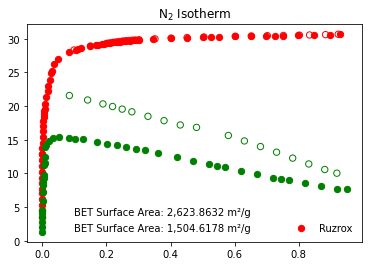

In [260]:

ind = 0
for i in filename:
    BET_SA = data_cleaning(i)[0]
    clean_iso = data_cleaning(i)[1]
    plot_ads_des(clean_iso,colors,ind)
    ind += 1
    plt.text(0.1, clean_iso.min().y * 1.05, BET_SA)
plt.savefig(i.replace(extension,'') + 'isocomb.png')
# ind = 0
# for i in filename:
#     clean_pv = data_cleaning(i)[2]
#     plot_pv(clean_pv,colors,ind)
#     ind += 1
#     plt.savefig(i.replace(extension,'') + 'pvcomb.png')

In [226]:
# iso = clean_iso.plot(x='x',y='y',
#                kind = 'scatter',
#                title='N$\mathregular{_{2}}$ Isotherm',
#                xlabel = 'Relative Pressure (p/p°)',
#                ylabel = 'Quantity Adsorbed (cm³/g)',
#                xlim = (0,1),
#                ylim = (clean_iso.min().y, clean_iso.max().y * 1.2),
#                label = filename[0].replace('.XLS','')
#               )
# iso.text(0.1, clean_iso.min().y * 1.5, BET_SA)
# plt.savefig(filename[0].replace('.XLS','') + 'iso.png')
# clean_pv.plot(x='x',y='y',
#               kind = 'line',
#               title='Pore Volume',
#               xlabel = 'Pore Width (Å)',
#               ylabel = 'dV/dlog(W) Pore Volume (cm³/g)',
#               xlim = (5,40),
#               ylim = (clean_pv.min().y, clean_pv.max().y * 1.1),
#               label = filename[0].replace('.XLS','')
#               )
# plt.savefig(filename[0].replace('.XLS','') + 'pv.png')

In [ ]:
# Rui's Code
# import csv
# import matplotlib.pyplot as plt
# import numpy as np

# def plot(filename, color, label_prefix):
#     X1 = np.array([])
#     Y1 = np.array([])
#     X2 = np.array([])
#     Y2 = np.array([])

#     with open(filename, newline='') as csvfile:
#         reader = csv.reader(csvfile, delimiter=',', quotechar='|')
#         last_row = None
#         for idx, row in enumerate(reader):
#             if idx == 0:
#                 continue
#             if last_row == None or float(row[0]) > float(last_row[0]):
#                 X1 = np.append(X1, float(row[0]))
#                 Y1 = np.append(Y1, float(row[1]))
#             else:
#                 X2 = np.append(X2, float(row[0]))
#                 Y2 = np.append(Y2, float(row[1]))
#             last_row = row

#     plt.scatter(X1, Y1, s=40, facecolors=color, edgecolors=color,label=label_prefix + '_adsorption')
#     plt.scatter(X2, Y2, s=40, facecolors='none', edgecolors=color,label=label_prefix + '_desorption')

# plot('NU-600B_isotherm.csv', 'red', 'NU-600')
# plot('NU-1008.csv', 'black', 'NU-1008')
# #plot('SALI-5.csv', 'orange', 'SALI-5')
# #plot('SALI-7.csv', 'blue', 'SALI-7')
# #plot('SALI-9-2.csv', 'green', 'SALI-9')

# plt.legend()
# plt.xlabel('Relative Pressure (P/P$_{0}$)')
# plt.ylabel('Quantity adsorbed(cm$^{3}$/g STP)')
# #plt.title('Perfluoroalkane-NU-1008')
# plt.show()